In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/CourseMaterial/Supervised Machine Learning/Deep Convolutional (DC) GAN

/content/drive/MyDrive/CourseMaterial/Supervised Machine Learning/Deep Convolutional (DC) GAN


# Import and process the data

In [4]:
import pandas as pd

data = pd.read_csv('mnist_train.csv')

In [5]:
data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data.shape

(60000, 785)

# Transforming Data to Numpy and Extract first 10000 samples

In [ ]:
data = np.array(data)
data = data[0:10000,:] # Extracting first 10000 samples

# Extracting only the Features

In [ ]:
X = data[:,1:]

In [ ]:
X.shape

(10000, 784)

# Normalize the Features between (-1, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
norm = MinMaxScaler( feature_range=(-1, 1) )
dataN = norm.fit_transform(X)

In [ ]:
dataT = torch.tensor( dataN, dtype = torch.float32 )

# Transform to 4D for DCGAN

In [ ]:
dataT = dataT.reshape(dataT.shape[0],1,28,28)

In [ ]:
dataT.shape

torch.Size([10000, 1, 28, 28])

# Create Discriminator class

In [ ]:
class discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(  1, 32, 4, 2, 1)
    self.conv2 = nn.Conv2d( 32, 64, 4, 2, 1)
    self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
    self.conv4 = nn.Conv2d(128, 1,  4, 1, 0)

    self.bn2 = nn.BatchNorm2d(64)
    self.bn3 = nn.BatchNorm2d(128)


  def forward(self,x):

    x = F.leaky_relu( self.conv1(x) ,0.2)  # 0.2 is the slope of leaky relu activation
    x = F.leaky_relu( self.conv2(x) ,0.2)
    x = self.bn2(x)
    x = F.leaky_relu( self.conv3(x) ,0.2)
    x = self.bn3(x)
    return torch.sigmoid( self.conv4(x) ).view(-1,1)

# Check the working of Discriminator

In [ ]:
disModel = discriminator()
out = disModel(torch.randn(10,1,28,28))
out.shape

torch.Size([10, 1])

# Create Generator class

In [ ]:
class generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.ConvTranspose2d(50, 128, 4, 1, 0)
    self.conv2 = nn.ConvTranspose2d(128, 64, 3, 2, 1)
    self.conv3 = nn.ConvTranspose2d( 64, 32, 4, 2, 1)
    self.conv4 = nn.ConvTranspose2d( 32, 1,  4, 2, 1)

    self.bn1 = nn.BatchNorm2d(128)
    self.bn2 = nn.BatchNorm2d(64)
    self.bn3 = nn.BatchNorm2d(32)


  def forward(self,x):

    x = F.relu( self.bn1(self.conv1(x)) )
    x = F.relu( self.bn2(self.conv2(x)) )
    x = F.relu( self.bn3(self.conv3(x)) )
    x = torch.tanh( self.conv4(x) )
    return x

# Check What Generator is producing without training

torch.Size([10, 1, 28, 28])


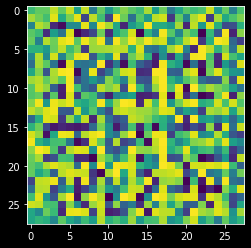

In [ ]:
genModel = generator()
out = genModel(torch.randn(10,50,1,1))
print(out.shape)
plt.imshow(out[0,:,:,:].squeeze().detach().numpy());

# Define a Loss Function

In [ ]:
lossfunc = nn.BCELoss() # For both Generator and Discriminator

# Pushing the DL Models to GPU

In [ ]:
disModel = disModel.to(device)
genModel = genModel.to(device)

# We need different optimizers for both models as their parameters are different.

In [ ]:
dis_optimizer = torch.optim.Adam(disModel.parameters(), lr=.0002)
gen_optimizer = torch.optim.Adam(genModel.parameters(), lr=.0002)

# Train the DCGAN

In [ ]:
epochs = 100001
batchsize = 32
losses  = np.zeros((epochs,2)) # (num_epochs,2) because we have to train two models i.e generator and discriminator.
dis_output = np.zeros((epochs,2)) # dis_output = discriminator decisions

for epoch in range(epochs):

  rand_idx = np.random.choice(dataT.shape[0], size= batchsize)
  real_images = dataT[rand_idx,:].to(device) # Real Images are generated from the real data (dataT)
  fake_images = genModel( torch.randn(batchsize,50,1,1).to(device) ) # Fake images are generated from the output of generator
                                                                 # by sending random input number to generator.


  # Creating Labels used for real and fake images

  real_labels = torch.ones(batchsize,1).to(device) # All ones means true because they are real labels
  fake_labels = torch.zeros(batchsize,1).to(device) # All zeros means false because they are fake labels


  # TRAIN THE DISCRIMINATOR

  # Forward pass and loss for REAL Images   (step1 of discriminator training)

  ypred_real   = disModel(real_images)                 # REAL images into discriminator
  dis_loss_real = lossfunc(ypred_real, real_labels)    # All labels are 1. In order to reduce loss model should learn to predict 1
                                                       # for real images

  # In the above step1 of training discriminator, we pass all real images to discriminator
  # and the comparing Ypred_real (predictions of discriminator) with real_labesl(all ones).
  # This is our loss which we have to minimize.



  # Forward pass and loss for FAKE Images (step 2 of discriminator training)

  ypred_fake   = disModel(fake_images)              # FAKE images into discriminator
  dis_loss_fake = lossfunc(ypred_fake, fake_labels)   # All labels are 0. In order to reduce loss model should learn to predict 0
                                                      # for fake images

  # Calculate combined loss.

  dis_loss = dis_loss_real + dis_loss_fake
  losses[epoch,0]  = dis_loss.item()   # loss will be accumulated along the first column
  dis_output[epoch,0] = torch.mean((ypred_real>.5).float()).detach() # This line is storing the model decision.


  # Backpropagation for discriminator

  dis_optimizer.zero_grad()
  dis_loss.backward()
  dis_optimizer.step()




  # TRAIN THE GENERATOR

  # Create the fake images and compute loss

  fake_images = genModel( torch.randn(batchsize,50,1,1).to(device) )
  ypred_fake   = disModel(fake_images)

  # In above two lines of code, we generate fake images from the generator
  # and pass the fake images through discriminator to get the predictions.




  # Compute loss and accuracy
  gen_loss = lossfunc(ypred_fake, real_labels)   # Here we comparing the predictions of
                                                 # of discriminator with the real_labels to get the loss of generator
                                                 # In this step we are trying to deceive to discriminator that our images are real. if
                                                 # discriminator accepts this then there is no loss, otherwise we need to train generator
                                                 # more so that it can fool the discriminator.
  losses[epoch,1]  = gen_loss.item()
  dis_output[epoch,1] = torch.mean((ypred_fake>.5).float()).detach()

  # Backpropagation of generator.

  gen_optimizer.zero_grad()
  gen_loss.backward()
  gen_optimizer.step()


  # printing the epochs
  if (epoch)%500==0:
    print(f' Epochs : {epoch}/{epochs}')



 Epochs : 0/100001
 Epochs : 500/100001
 Epochs : 1000/100001
 Epochs : 1500/100001
 Epochs : 2000/100001
 Epochs : 2500/100001
 Epochs : 3000/100001
 Epochs : 3500/100001
 Epochs : 4000/100001
 Epochs : 4500/100001
 Epochs : 5000/100001
 Epochs : 5500/100001
 Epochs : 6000/100001
 Epochs : 6500/100001
 Epochs : 7000/100001
 Epochs : 7500/100001
 Epochs : 8000/100001
 Epochs : 8500/100001
 Epochs : 9000/100001
 Epochs : 9500/100001
 Epochs : 10000/100001
 Epochs : 10500/100001
 Epochs : 11000/100001
 Epochs : 11500/100001
 Epochs : 12000/100001
 Epochs : 12500/100001
 Epochs : 13000/100001
 Epochs : 13500/100001
 Epochs : 14000/100001
 Epochs : 14500/100001
 Epochs : 15000/100001
 Epochs : 15500/100001
 Epochs : 16000/100001
 Epochs : 16500/100001
 Epochs : 17000/100001
 Epochs : 17500/100001
 Epochs : 18000/100001
 Epochs : 18500/100001
 Epochs : 19000/100001
 Epochs : 19500/100001
 Epochs : 20000/100001
 Epochs : 20500/100001
 Epochs : 21000/100001
 Epochs : 21500/100001
 Epochs : 22

# Low pass filter for smoothing the losses

In [ ]:
def smooth(x,k=21):
  return np.convolve(x,np.ones(k)/k,mode='same')

# Visualizing the Performance

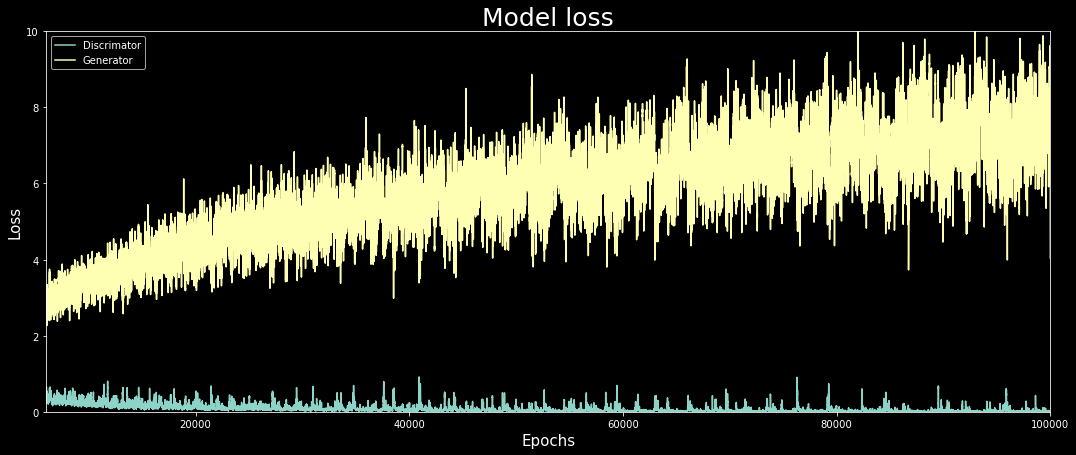

In [ ]:
plt.figure(figsize=(18,7))
plt.plot(smooth(losses[:,0]))
plt.plot(smooth(losses[:,1]))
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('Model loss', fontsize = 25)
plt.legend(['Discrimator','Generator'])
plt.xlim([6000,100000])
plt.ylim([0,10])
plt.show()

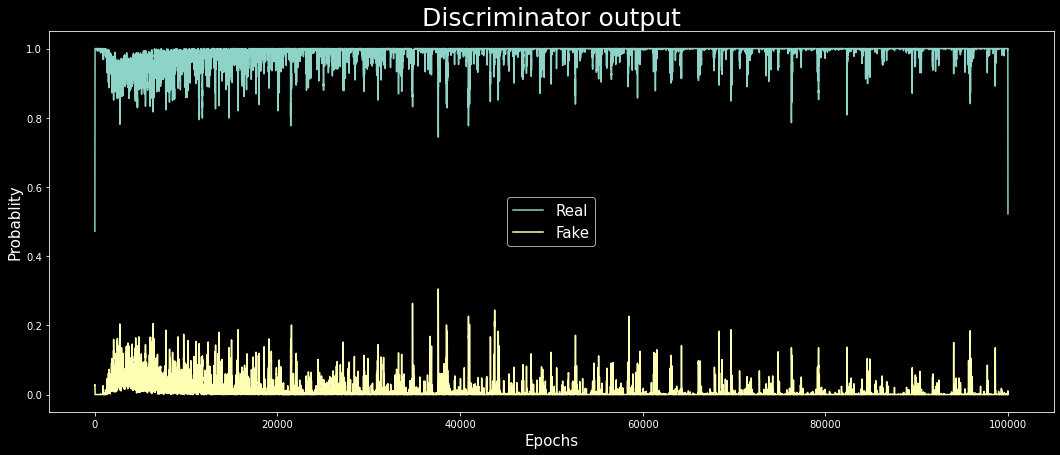

In [ ]:
plt.figure(figsize=(18,7))
plt.plot(smooth(dis_output[:,0]))
plt.plot(smooth(dis_output[:,1]))
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Probablity',fontsize = 15)
plt.title('Discriminator output', fontsize = 25)
plt.legend(['Real','Fake'], fontsize = 15)
plt.show()

# Test the Generator with random samples

In [ ]:
Noise = torch.randn(batchsize,50,1,1)

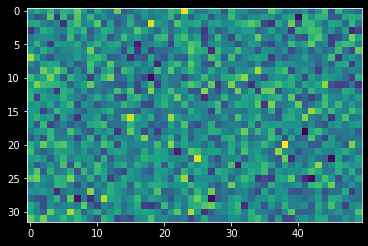

In [ ]:
plt.imshow(Noise.squeeze())

In [ ]:
genModel.eval()
fake_data = genModel(Noise.to(device))
fake_data = fake_data.cpu()

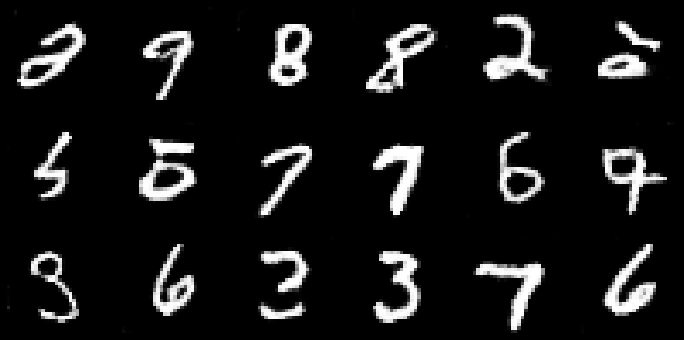

In [ ]:
fig,axis = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axis.flatten()):
  ax.imshow(fake_data[i,].detach().squeeze(),cmap='gray')
  ax.axis('off')
plt.show()

In [ ]:
# fig,axis = plt.subplots(3,6,figsize=(12,6))
# for i,ax in enumerate(axis):
#   ax.imshow(fake_data[i,].detach().squeeze(),cmap='gray')
#   ax.axis('off')
# plt.show()